Deep CNN Model Training using Transfer Learning

**In this tutorial, we will intorduce concept of transfer learning in state-of-art CNNs.** 

* Transfer learning is a method where knowledge gathered from one problem are used to solve similar or new problem.
* Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

**A. How to perform transfer learning?**
1. Take layers from a previously trained model.
2. Freeze all/some initial layers of the model.
3. Add some new layers in the model.
4. Train the new layers on new dataset.

**B. How to perform fine-tuning?**
1. Unfreezing the entire model 
2. Re-training it on the new data

**Mount the Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Move to the folder where dataset is uploaded in Google drive**

In [12]:
%cd /content/drive/My\ Drive/NIELIT_practical/COVID\ Data/DATA

/content/drive/My Drive/NIELIT_practical/COVID Data/DATA


**List the files and folders present in the Google drive folder**

In [13]:
!ls

test  train


**Import necessary packages**

In [14]:
import os
import numpy as np
import tensorflow.keras

**Data Preprocessing**

Keras provides the ImageDataGenerator class for data preprocessing and data augmentation.

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   horizontal_flip=True, vertical_flip=True, 
                                   rotation_range=15,
                                   shear_range=15,
                                   zoom_range=0.15)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'train',
        target_size=(299, 299),
        batch_size=64,
        class_mode='categorical'
        )
 

test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(299, 299),
        batch_size=64,
        class_mode='categorical',
        shuffle=False)

validation_generator = test_generator

Found 637 images belonging to 3 classes.
Found 88 images belonging to 3 classes.


**A. Implementation of tranfer learning using keras:**

1. Instantiate a base model and load pre-trained weights into it.
2. Freeze all layers in the base model by setting trainable = False.
3. Create a new model on top of the output of one (or several) layers from the base model.
4. Train new model on new dataset.


**A.1 Loading the Inceptionv3 model with ImageNet pre-trained weights**

In [17]:
base_model = tensorflow.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(299, 299,3)
)
base_model.summary()

87916544/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________

**A.2 Freeze all the layers of Inceptionv3**

In [18]:
base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

**A.3 Adding new layers to Inception model**


In [27]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
 
# Create the model
model = models.Sequential()
# Add the Inception convolutional base model
model.add(base_model)

# Add new layers
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(3, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


**A.4 Model Compilation**

In [30]:
loss = tensorflow.keras.losses.CategoricalCrossentropy(from_logits=False)
model.compile(loss=loss, optimizer='adam', metrics=['acc'])

**A.5 Model Training**

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='_inception_best_weights.hdf5'
checkpointer=ModelCheckpoint(filepath,monitor='val_acc',mode='max',save_best_only=True,verbose=1)
epochs = 10
history=model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        callbacks=[checkpointer],
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size,
        verbose=1)

Epoch 1/10
9/9 [==============================] - 96s 11s/step - loss: 0.8846 - acc: 0.5707 - val_loss: 1.4201 - val_acc: 0.1875

Epoch 00001: val_acc improved from -inf to 0.18750, saving model to _inception_best_weights.hdf5
Epoch 2/10
9/9 [==============================] - 11s 1s/step - loss: 0.6479 - acc: 0.7083 - val_loss: 1.0899 - val_acc: 0.3594

Epoch 00002: val_acc improved from 0.18750 to 0.35938, saving model to _inception_best_weights.hdf5
Epoch 3/10
9/9 [==============================] - 11s 1s/step - loss: 0.5345 - acc: 0.7679 - val_loss: 0.7047 - val_acc: 0.6250

Epoch 00003: val_acc improved from 0.35938 to 0.62500, saving model to _inception_best_weights.hdf5
Epoch 4/10
9/9 [==============================] - 11s 1s/step - loss: 0.4771 - acc: 0.8063 - val_loss: 0.8300 - val_acc: 0.5469

Epoch 00004: val_acc did not improve from 0.62500
Epoch 5/10
9/9 [==============================] - 11s 1s/step - loss: 0.3834 - acc: 0.8621 - val_loss: 0.6119 - val_acc: 0.6875

Epoch 0

**A.6 Testing the performance of the model**

In [32]:
test_output= model.evaluate_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
print(test_output)
print(model.metrics_names)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


1/1 [==============================] - 2s 4s/step - loss: 0.5851 - acc: 0.6932           
[0.5850779414176941, 0.6931818127632141]
['loss', 'acc']


**A.7 Plotting the training accuracy and loss graph**

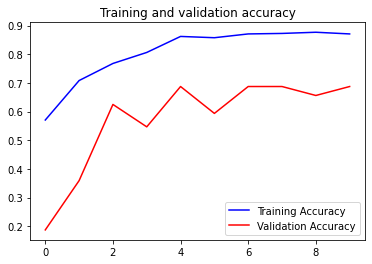

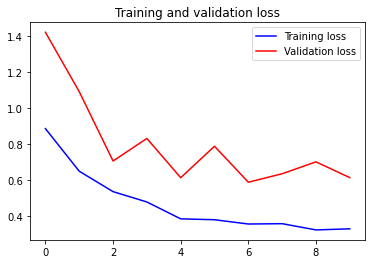

In [33]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

###**Fine-tuning**

**B.1 Loading the Inception V3 model with ImageNet pre-trained weights**

In [35]:
new_base_model = tensorflow.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(299, 299,3)
)
new_base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

**B.2 Adding new layers to Inceptionv3 model**


In [36]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
 
# Create the model
new_model = models.Sequential()
# Add the Inception v3 convolutional base model
new_model.add(new_base_model)

# Add new layers
new_model.add(layers.GlobalAveragePooling2D())

new_model.add(layers.Dense(3, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 21,774,499
Non-trainable params: 34,432
_________________________________________________________________


**B.3 Model Compilation**

In [37]:
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

**B.4 Model Training**

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='inception_finetuning_best_weights.hdf5'
checkpointer=ModelCheckpoint(filepath,monitor='val_acc',mode='max',save_best_only=True,verbose=1)
epochs = 20
new_history=new_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        callbacks=[checkpointer],
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size,
        verbose=1)

Epoch 1/10
9/9 [==============================] - 13s 1s/step - loss: 0.1232 - acc: 0.9546 - val_loss: 5.7903 - val_acc: 0.5625

Epoch 00001: val_acc improved from -inf to 0.56250, saving model to inception_finetuning_best_weights.hdf5
Epoch 2/10
9/9 [==============================] - 14s 1s/step - loss: 0.0987 - acc: 0.9616 - val_loss: 1.6974 - val_acc: 0.8125

Epoch 00002: val_acc improved from 0.56250 to 0.81250, saving model to inception_finetuning_best_weights.hdf5
Epoch 3/10
9/9 [==============================] - 13s 1s/step - loss: 0.0930 - acc: 0.9634 - val_loss: 1.0681 - val_acc: 0.7656

Epoch 00003: val_acc did not improve from 0.81250
Epoch 4/10
9/9 [==============================] - 13s 1s/step - loss: 0.0992 - acc: 0.9599 - val_loss: 0.2706 - val_acc: 0.9219

Epoch 00004: val_acc improved from 0.81250 to 0.92188, saving model to inception_finetuning_best_weights.hdf5
Epoch 5/10
9/9 [==============================] - 14s 1s/step - loss: 0.0747 - acc: 0.9686 - val_loss: 0.10

**B.5 Testing the performance of the model**

In [47]:
test_output= new_model.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
print(test_output)
print(model.metrics_names)

1/1 [==============================] - 1s 258ms/step - loss: 0.4639 - acc: 0.8750       
[0.4638921618461609, 0.875]
['loss', 'acc']


**B.6 Plotting the training accuracy and loss graph**

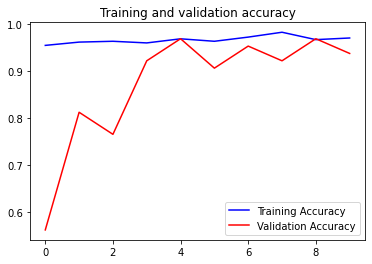

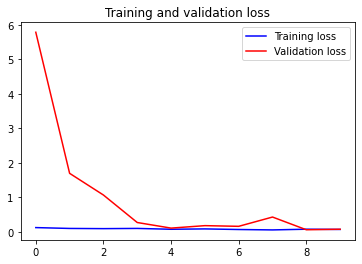

In [48]:
import matplotlib.pyplot as plt
acc = new_history.history['acc']
val_acc = new_history.history['val_acc']
loss = new_history.history['loss']
val_loss = new_history.history['val_loss']
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()